# Milestone 1

## Download the data

The data used for this project is taken from the `brise-plandok` project on [github](https://github.com/recski/brise-plandok). It is already separated in a test, train and validation set. The following python script can also be executed from command line using python `python download.py` in the `data` directory.

In [1]:
import requests

csv_urls = [
    "https://raw.githubusercontent.com/recski/brise-plandok/main/brise_plandok/baselines/input/test_data.csv",
    "https://raw.githubusercontent.com/recski/brise-plandok/main/brise_plandok/baselines/input/train_data.csv",
    "https://raw.githubusercontent.com/recski/brise-plandok/main/brise_plandok/baselines/input/valid_data.csv"
]
for url in csv_urls:
    r = requests.get(url, allow_redirects=True)
    set = url.split("/")[-1].split("_")[0]
    open(f'../data/{set}_data.csv', 'wb').write(r.content)

## Preprocessing

### Setup for preprocessing

In [2]:
import nltk
import stanza
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from data.constants import ALL_LABELS_SORTED

In [3]:
nltk.download('stopwords')
german_stop_words = nltk.corpus.stopwords.words('german')
stanza.download('de')
nlp=stanza.Pipeline(processors="tokenize,mwt,lemma", lang="de",use_gpu=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2022-12-04 22:30:44 INFO: Downloading default packages for language: de (German) ...
2022-12-04 22:30:52 INFO: File exists: C:\Users\maxha\stanza_resources\de\default.zip
2022-12-04 22:30:59 INFO: Finished downloading models and saved to C:\Users\maxha\stanza_resources.
2022-12-04 22:30:59 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-12-04 22:31:00 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| lemma     | gsd     |

2022-12-04 22:31:01 INFO: Use device: gpu
2022-12-04 22:31:01 INFO: Loading: tokenize
2022-12-04 22:31:09 INFO: Loading: mwt
2022-12-04 22:31:09 INFO: Loading: lemma
2022-12-04 22:31:10 INFO: Done loading processors!


In [4]:
# Path to csv files
WD = '../'
data_path = WD + 'data/'
train_df = pd.read_csv(data_path + 'train_data.csv')
valid_df = pd.read_csv(data_path + 'valid_data.csv')
test_df = pd.read_csv(data_path + 'test_data.csv')

In [5]:
def tokenize(input: str):
    doc = nlp(input)
    return [word.lemma  for sent in doc.sentences for word in sent.words if word.lemma not in german_stop_words]

def preprocess_features(df: pd.DataFrame, type_of_data: str, vocab=None):
    vectorizer = CountVectorizer(tokenizer=tokenize, vocabulary=vocab, lowercase=False)
    features = df.iloc[:, [0, 1]].copy()
    vectors = vectorizer.fit_transform(features.Text).toarray()
    transformed_features = pd.DataFrame(vectors, columns=vectorizer.get_feature_names_out())
    features=features.join(transformed_features)
    features.to_csv((data_path+type_of_data + '_features.csv'), index=False)
    return features.columns[2:].tolist()

def preprocess_labels(df: pd.DataFrame, type_of_data: str):
    labels =  df.iloc[:, [0, 2]].copy()
    labels.Labels = labels.Labels.apply(ast.literal_eval)
    mlb = MultiLabelBinarizer(classes=list(ALL_LABELS_SORTED.keys()))
    labels_transformed = mlb.fit_transform(labels['Labels'])
    labels[mlb.classes_] = labels_transformed
    labels.to_csv((data_path + type_of_data + '_labels.csv'), index=False)

def preprocess_df(df: pd.DataFrame, type_of_data: str, vocab=None):
    vocab = preprocess_features(df, type_of_data, vocab)
    preprocess_labels(df, type_of_data)
    return vocab

### Run preprocessing

The following code extracts features and labels as new csv files from the original files `test_data.csv`, `train_data.csv` and `valid_data.csv`. The newly constructed csv files will be used for our model.

In [6]:
%%time
vocab = preprocess_df(train_df, 'train')
preprocess_df(valid_df, 'valid', vocab)
vocab=preprocess_df(test_df, 'test', vocab)

CPU times: total: 5min 27s
Wall time: 6min 45s


## Training

For this exercise, we chose to train a random forest classifier and a multi-layer perceptron classifier.

### Setup for training

Our team first settled for a random forest classifier, the choice has been driven by the ease of training and RF capacity of handling categories or categorical variables in general. During the project we decided on comparing its performance with a multi-layer perceptron classifier.

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

In [8]:
df_features = pd.read_csv(data_path + 'train_features.csv')
df_labels = pd.read_csv(data_path + 'train_labels.csv')
valid_features = pd.read_csv(data_path + 'valid_features.csv')
valid_labels = pd.read_csv(data_path + 'valid_labels.csv')

In [9]:
y_train = df_labels.iloc[:, 2:].copy()
x_train = df_features.iloc[:, 2:].copy()
y_test = valid_labels.iloc[:, 2:].copy()
x_test = valid_features.iloc[:, 2:].copy()

In [10]:
classifier_rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
classifier_deep = MLPClassifier(random_state=1, max_iter=290) # number of iterations chosen so that optimization converges

## Perform training

In [11]:
%%time
classifier_rf.fit(x_train, y_train)
classifier_deep.fit(x_train, y_train)

CPU times: total: 5min 22s
Wall time: 6min 30s


MLPClassifier(max_iter=290, random_state=1)

## Evaluation

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

In [13]:
y_pred_rf = classifier_rf.predict(x_test)
y_pred_deep = classifier_deep.predict(x_test)

In [14]:
report_rf=metrics.classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
report_deep=metrics.classification_report(y_test, y_pred_deep, output_dict=True, zero_division=0)

### Metrics for multi-label classification

We have unbalanced classes, this is a feature to take into account. Maybe tuning loss functions to care about weights. So, accuracy is not a good metric. Better precision, recall, f1-score etc. For each class, we can compute the usual metrics for binary classification and the confusion matrix. Aggregated metrics like macro, micro, weighted and sampled avg give us a high-level view of how our model is performing.

- <b>Macro Average</b>
This is simply the average of a metric — precision, recall or f1-score — over all classes.

- <b>Micro Average</b>
The micro-average of a metric is calculated by considering all the TP, TN, FP and FN for each class, adding them up and then using those to compute the metric’s micro-average

- <b>Weighted Average</b>
This is simply the average of the metric values for individual classes weighted by the support of that class. The support is how many times a class appeared in y_test.

- <b>Samples Average</b>
Here, we compute metrics for each sample and then average them.

# Comments
These are preliminary results, obviously to have a robust model we still need to evaluate through, for example, cross-validation on train+validation and then test it in the test set.
From the reports, we can also see that some classes are not represented. More focus on this point is needed. Either to make sure the model can be trained on that, or study a model able to generalize.
Both the models can be fine tuned in the hyperparameter space, or even extended (using bagging for RF for example, or more complex networks to be evaluated.)

In [15]:
macros=['micro avg','macro avg','weighted avg','samples avg']
scores=['precision','recall','f1-score']
df = pd.DataFrame(columns=['model','measure','value'])

for macro in macros:
    for score in scores:
        df.loc[len(df)] = ['rf',macro+'-'+score, report_rf[macro][score]]
        df.loc[len(df)] = ['deep',macro+'-'+score, report_deep[macro][score]]

display(df[df["model"]=="rf"]),display(df[df["model"]=="deep"])

,model,measure,value
0,rf,micro avg-precision,0.949807
2,rf,micro avg-recall,0.693609
4,rf,micro avg-f1-score,0.801738
6,rf,macro avg-precision,0.607036
8,rf,macro avg-recall,0.447390
10,rf,macro avg-f1-score,0.494686
12,rf,weighted avg-precision,0.914414
14,rf,weighted avg-recall,0.693609
16,rf,weighted avg-f1-score,0.766931
18,rf,samples avg-precision,0.532251


,model,measure,value
1,deep,micro avg-precision,0.919878
3,deep,micro avg-recall,0.852444
5,deep,micro avg-f1-score,0.884878
7,deep,macro avg-precision,0.677706
9,deep,macro avg-recall,0.620751
11,deep,macro avg-f1-score,0.638874
13,deep,weighted avg-precision,0.910788
15,deep,weighted avg-recall,0.852444
17,deep,weighted avg-f1-score,0.874595
19,deep,samples avg-precision,0.567686


(None, None)

The above table demonstrates the performance of ours classifiers. We can see that - in most cases - the multi-layer perceptron classifier yields better results than the random forest classifier. This property is visualized in the following plot.

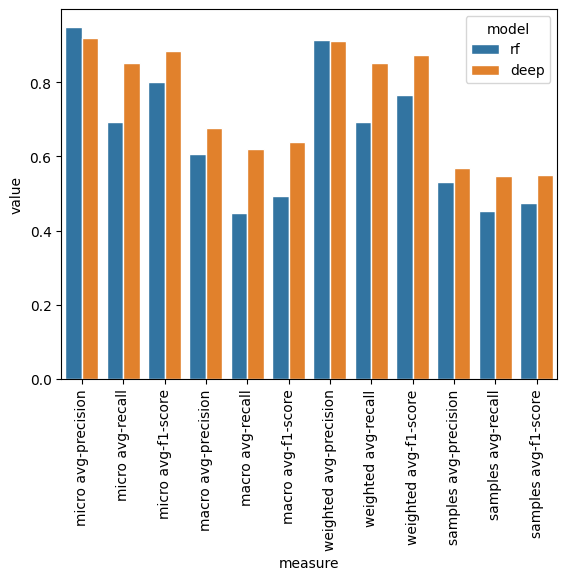

In [16]:
sns.barplot(x='measure', y='value', hue='model', data=df,
            palette='tab10', edgecolor='w')
plt.xticks(rotation=90)
plt.show()

In [17]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

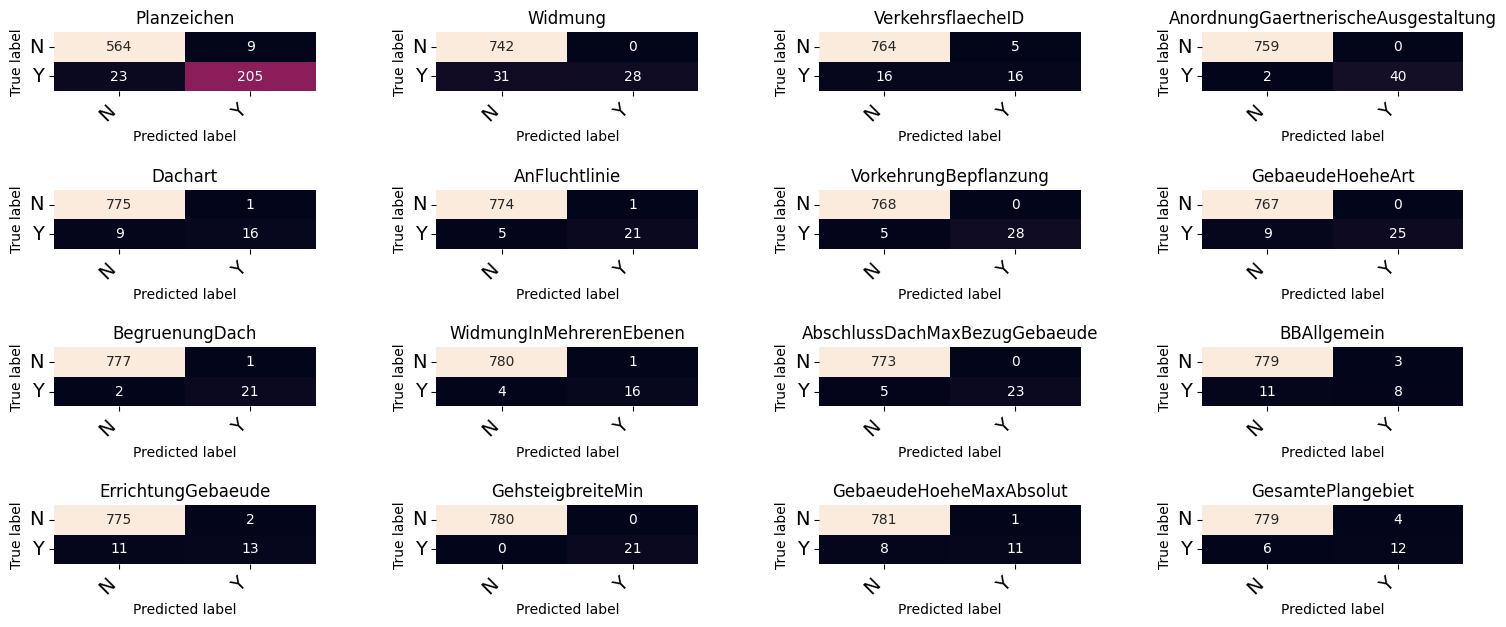

In [18]:
vis_arr = multilabel_confusion_matrix(y_test, y_pred_rf)
labels =  y_test.columns
fig, ax = plt.subplots(4, 4, figsize=(16, 7))
fig.tight_layout(pad=5.0)

for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

plt.show()

## Qualitative Analysis

The confusion matrices above show that each class does not have many occurrences in the data set. Thus, the classifier seems to perform quite well when predicting negatives than positives. For every label, the number of FN is equal or smaller than the number of FP except for the label "Planzeichen". This label occurred more often in the data.

For some labels, the classification can be derived from specific keywords. For example predicting the label "AnordnungGaertnerischeAugestaltung" depends on certain keywords like "begrünen" or "gärtnerisch" which seems obvious. The same applies for the label "GehsteigBreiteMin" which highly depends on the occurrence of the word "Gehsteig" (which also is quite obvious).

One problem of the current feature set is that some features are places ("ottakring", "wagram", "erzherzogkarlstraße", "oktober"). Whilst these features might be meaningful for the current data and gives some insights on the training data, they should not be considered for classification tasks. They introduce a bias to the classification that will just add noise in the long run.

For our application, both recall and precision are important as we want the classifier to be sensitive enough to not miss any cases but also don't want it to add incorrect annotations that have to be manually checked afterwards. So considering the f1-score, the MLP classifier yields much better results.

The difference in the choice of the classifier can be seen when looking at the confusion matrix of the label "Widmung". The label has 55 TP cases with the MLP classifier and only 24 with RF. The same applied for the label "BBAllgemein".

We can see that overall, the classification results are good. They are by far not perfect but we also did not tune hyperparameters or used more sophisticated transformations. Further experiments could be the exclusion of variables that imply unwanted bias and dimensionality reduction. Dimensionality reduction should not be done using PCA, though, because we are dealing with descrete data. NMF, PLSA or PLDA could be used for this task.

To sum it up, the MLP classifier yielded better results than the random forest. The classification is good but can probably be improved. Therefore, one would need to tune the hyperparameters and might have to employ methods for feature selection or dimensionality reduction.